<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-of-dataset" data-toc-modified-id="Introduction-of-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction of dataset</a></span><ul class="toc-item"><li><span><a href="#Descriptive-Statistics" data-toc-modified-id="Descriptive-Statistics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Descriptive Statistics</a></span></li></ul></li><li><span><a href="#NER-model" data-toc-modified-id="NER-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NER model</a></span></li></ul></div>

Name: Jiangnan HUANG, You ZUO

Date: 12/01/2021

# Introduction of dataset

We will use two datasets with named entity annotations : a small medical corpus (QUAERO_FrenchMed) and a larger news corpus (QUAERO_FrenchPress).

The datasets are provided in conll-like format and contain five columns separated by white spaces. Each word (or token) corresponds to a line and sentences are separated by an empty line.

The columns correspond to: the token index within the sentence, the token, two columns that will not be used in this lab and finally, the last column contains the named entity tag.

In [1]:
import re 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename, "r", encoding='utf-8')
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = line.strip().split()
        if cleanline: #and (cleanline[1].isalpha() or cleanline[1].isdigit()): 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
#     print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return np.asarray(dataset)

In [3]:
# nb of sentences, words, ner, uniq ner
def stat_descrip(dataset):
    res = {}
    res['Tokens'] = len(dataset)
    
    ners = {'context':[], 'type':[]}
    
    for data in dataset:
        if data[-1]!='O': 
            ners['type'].append(data[-1])
            ners['context'].append(data[1])
            
    res['Entities'] = len(ners['context'])
    res['Unique Entities'] = len(np.unique(ners['context']))
    res['Sentences'] = np.sum(dataset[:,0]=='1')
    
    return res,ners

In [4]:
# load all the texts
EMEAtrain=loadTexts('../TP_ISD2020/QUAERO_FrenchMed/EMEA/EMEAtrain_layer1_ID.conll')
EMEAdev=loadTexts('../TP_ISD2020/QUAERO_FrenchMed/EMEA/EMEAdev_layer1_ID.conll')
EMEAtest=loadTexts('../TP_ISD2020/QUAERO_FrenchMed/EMEA/EMEAtest_layer1_ID.conll')

Presstrain=loadTexts('../TP_ISD2020/QUAERO_FrenchPress/fra4_ID.train')
Pressdev=loadTexts('../TP_ISD2020/QUAERO_FrenchPress/fra4_ID.dev')
Presstest=loadTexts('../TP_ISD2020/QUAERO_FrenchPress/fra4_ID.test')

In [5]:
show_head = pd.DataFrame(EMEAtrain).head(10)
show_head

,0,1,2,3,4
0,1,PRIALT,21,27,B-CHEM
1,1,EMEA,0,4,O
2,2,/,5,6,O
3,3,H,7,8,O
4,4,/,9,10,O
5,5,C,11,12,O
6,6,/,13,14,O
7,7,551,15,18,O
8,1,Qu,30,32,O
9,2,’,33,34,O


## Descriptive Statistics 

In [6]:
EMEA_stat = pd.DataFrame.from_dict(stat_descrip(EMEAtrain)[0], orient='index',columns=['Train.'])


EMEA_stat = pd.concat([EMEA_stat, pd.DataFrame.from_dict(stat_descrip(EMEAdev)[0], orient='index',columns=['Dev.'])], 
                      axis=1)

EMEA_stat = pd.concat([EMEA_stat, pd.DataFrame.from_dict(stat_descrip(EMEAtest)[0], orient='index',columns=['Test.'])], 
                      axis=1)

EMEA_stat

,Train.,Dev.,Test.
Tokens,15339,13543,12388
Entities,3198,2704,2604
Unique Entities,914,739,664
Sentences,706,649,578


In [7]:
Press_stat = pd.DataFrame.from_dict(stat_descrip(Presstrain)[0], orient='index',columns=['Train.'])


Press_stat = pd.concat([Press_stat, pd.DataFrame.from_dict(stat_descrip(Pressdev)[0], orient='index',columns=['Dev.'])], 
                      axis=1)

Press_stat = pd.concat([Press_stat, pd.DataFrame.from_dict(stat_descrip(Presstest)[0], orient='index',columns=['Test.'])], 
                      axis=1)

Press_stat

,Train.,Dev.,Test.
Tokens,1156339,95222,95807
Entities,135268,9869,6296
Unique Entities,12778,2652,2227
Sentences,35723,2825,2880


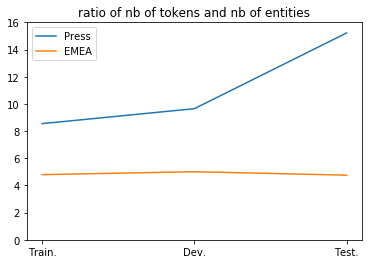

In [8]:
plt.plot(Press_stat.loc['Tokens',:] / Press_stat.loc['Entities',:],label='Press' )

plt.plot(EMEA_stat.loc['Tokens',:] / EMEA_stat.loc['Entities',:],label='EMEA')

plt.ylim(0,16)
plt.legend()
plt.title('ratio of nb of tokens and nb of entities')

plt.show()

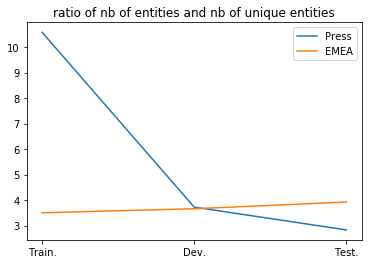

In [9]:
plt.plot(Press_stat.loc['Entities',:] / Press_stat.loc['Unique Entities',:],label='Press' )

plt.plot(EMEA_stat.loc['Entities',:] / EMEA_stat.loc['Unique Entities',:],label='EMEA')

plt.legend()
plt.title('ratio of nb of entities and nb of unique entities')

plt.show()

In [10]:
def plot_freq(data, label):
    
    plt.bar((*np.unique(data, return_counts=True))) 
    plt.xlabel('Entity')
    plt.ylabel('Freq')
    plt.title('Entity frequency of '+str(label))

<Figure size 432x288 with 0 Axes>

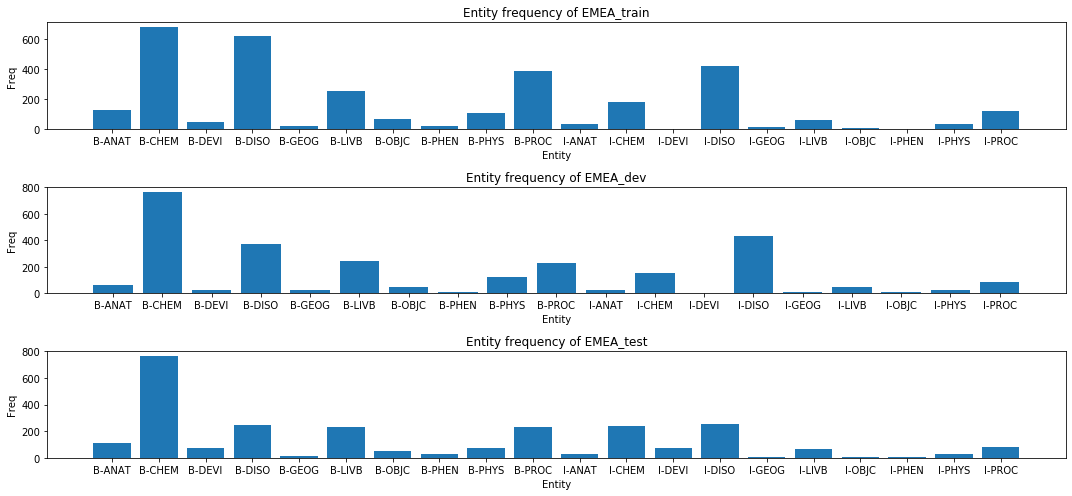

In [11]:
plt.subplots_adjust(hspace=3) 
fig=plt.figure(figsize=(15,7))

plt.subplot(311)
plot_freq(stat_descrip(EMEAtrain)[1]['type'],label='EMEA_train')

plt.subplot(312)
plot_freq(stat_descrip(EMEAdev)[1]['type'],label='EMEA_dev')

plt.subplot(313)
plot_freq(stat_descrip(EMEAtest)[1]['type'],label='EMEA_test')
fig.tight_layout()

plt.show()

<Figure size 432x288 with 0 Axes>

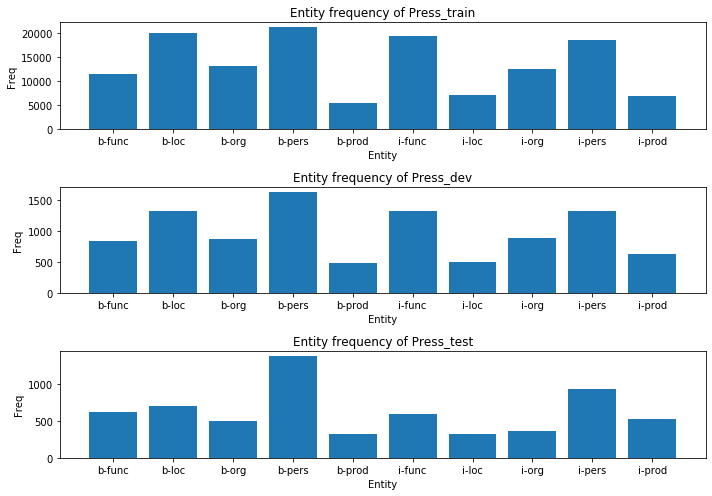

In [12]:
plt.subplots_adjust(hspace=3) 
fig=plt.figure(figsize=(10,7))

plt.subplot(311)
plot_freq(stat_descrip(Presstrain)[1]['type'],label='Press_train')

plt.subplot(312)
plot_freq(stat_descrip(Pressdev)[1]['type'],label='Press_dev')

plt.subplot(313)
plot_freq(stat_descrip(Presstest)[1]['type'],label='Press_test')
fig.tight_layout()

plt.show()

# NER model 

In [13]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec, FastText

cbow_medical = Word2Vec.load('../tp1/models/cbow_medical.model')
skipgram_medical = Word2Vec.load('../tp1/models/skipgram_medical.model')
fasttext_medical = FastText.load('../tp1/models/fasttext_medical.model')

cbow_non_medical = Word2Vec.load('../tp1/models/cbow_non-medical.model')
skipgram_non_medical = Word2Vec.load('../tp1/models/skipgram_non-medical.model')
fasttext_non_medical = FastText.load('../tp1/models/fasttext_non-medical.model')

In [14]:
dim = cbow_medical.wv.vectors.shape
voc = cbow_medical.wv.index2word
vec = cbow_medical.wv.vectors

In [15]:
import os
import gzip

# save word embeddings in a certain form
def save_vec(model, filename):
    dim = model.wv.vectors.shape 
    voc = model.wv.index2word
    vec = model.wv.vectors

    f = gzip.open(filename, "wt", encoding="utf-8")
    f.write(str(dim[0])+' '+str(dim[1])+'\n')
    for i in range(dim[0]):
        temp = voc[i]+' '
        for vec_item in vec[0]:
            temp += str(vec_item) + ' '
        f.write(temp)
        f.write('\n')
    f.close()

In [16]:
save_vec(cbow_medical,'cbow_med.vec.gz')
save_vec(cbow_non_medical,'cbow_press.vec.gz')

save_vec(skipgram_medical,'skip_med.vec.gz')
save_vec(skipgram_non_medical,'skip_press.vec.gz')

save_vec(fasttext_medical,'fasttext_med.vec.gz')
save_vec(fasttext_non_medical,'fasttext_press.vec.gz')

# Training embeddings with smaller size of corpus

In [17]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    """
    string = re.sub(r"[!?,.\'\`]", " ", string)   
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename, "r", encoding='utf-8')
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(line).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset

In [18]:
filename = '../TP_ISD2020/QUAERO_FrenchMed/QUAERO_FrenchMed_traindev.ospl'

# read only the first 2000 lines
embed_data1 = loadTexts(filename,limit=2000)

# read only the first 1000 lines
embed_data2 = loadTexts(filename,limit=1000)

Load  2000  lines from  ../TP_ISD2020/QUAERO_FrenchMed/QUAERO_FrenchMed_traindev.ospl  /  69  lines discarded
Load  1000  lines from  ../TP_ISD2020/QUAERO_FrenchMed/QUAERO_FrenchMed_traindev.ospl  /  49  lines discarded


In [19]:
# word2vec: skipgram
## skipgram trained on data
w2v_sg1 = Word2Vec(sg=1, min_count=1, size=100, window=10)
w2v_sg1.build_vocab(sentences=embed_data1)
w2v_sg1.train(embed_data1,total_examples=w2v_sg1.corpus_count, epochs=20)

(508497, 690100)

In [20]:
## skipgram trained on data2
w2v_sg2 = Word2Vec(sg=1, min_count=1, size=100, window=10)
w2v_sg2.build_vocab(sentences=embed_data2)
w2v_sg2.train(embed_data2,total_examples=w2v_sg2.corpus_count, epochs=20)

(294589, 408400)

In [21]:
# save embeddings
save_vec(w2v_sg1,'skip_sub2000_med.vec.gz')
save_vec(w2v_sg2,'skip_sub1000_med.vec.gz')